[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.<br>
For this notebook you will need to download the **Cotton-100619-Healthy-zz-V1-20210225102300**, **Black nightsade-220519-Weed-zz-V1-20210225102034**, **Tomato-240519-Healthy-zz-V1-20210225103740** and **Velvet leaf-220519-Weed-zz-V1-20210225104123** datasets from [Eden Library](https://edenlibrary.ai/datasets), and you may want to use the **eden_pytorch_transfer_learning.yml** file to recreate a suitable conda environment.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

## Background

Open Neural Network Exchange ONNX provides an open source format for AI models, both deep learning and traditional ML. It defines an extensible computation graph model, as well as definitions of built-in operators and standard data types. 

ONNX is widely supported and can be found in many frameworks, tools, and hardware. Enabling interoperability between different frameworks and streamlining the path from research to production helps increase the speed of innovation in the AI community

ONNX Runtime is a performance-focused engine for ONNX models, which inferences efficiently across multiple platforms and hardware (Windows, Linux, and Mac and on both CPUs and GPUs). ONNX Runtime has proved to considerably increase performance over multiple models.

For this tutorial, you will need to install ONNX and ONNX Runtime. You can get binary builds of ONNX and ONNX Runtime with pip install onnx onnxruntime. Note that ONNX Runtime is compatible with Python versions 3.5 to 3.7.

In this notebook we are going to make use of ONNX format and export our model from PyTorch to ONNX. Furthermore, we are going to use onnnxruntime to run inference.

In this notebook, we are going to cover a technique called **Transfer Learning**, which generally refers to a process where a machine learning model is trained on one problem, and afterwards, it is reused in some way on a second (possibly) related problem (Bengio, 2012). Specifically, in **deep learning**, this technique is used by training only some layers of the pre-trained network. Its promise is that the training will be more efficient and in the best of the cases the performance will be better compared to a model trained from scratch. In this example we are using ResNet architecture and the PyTorch framework.

It is important to note that in this notebook, inspite of making use of ONNX, we are also using the PyTorch framework to design and train our neural networks. This represents an extension over the previous Eden notebooks:
1. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-1.ipynb
2. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-2.ipynb
3. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-3.ipynb
4. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-4.ipynb
5. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-5.ipynb

### Importing Libraries

In [1]:
# In case it is not installed in your system run pip installs ( Google Colab doesn't have onnx by default)
!pip install onnx
!pip install onnxruntime

     |████████████████████████████████| 12.2MB 255kB/s 
     |████████████████████████████████| 4.5MB 9.0MB/s 


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import shutil

# onnx necessary packages
import torch.onnx
import onnx
import onnxruntime

plt.ion()  # interactive mode

### Folder structuring 
We are going to create a main data folder 'eden_data' that will contain the 4 different datasets. We will also split the datasets into train and validation sub-sets. 

In [3]:
# Change paths to suit your system (this was created for google colab)
!mkdir /content/eden_data
main_folder = "/content/eden_data/"

# Create train and val folders that will host the data.
train_path = "/content/eden_data/train"
if not os.path.exists(train_path):
    os.makedirs(train_path)
val_path = "/content/eden_data/val"
if not os.path.exists(val_path):
    os.makedirs(val_path)

classes = ["BlackNightsade", "Tomato", "Cotton", "Velvet leaf"]
num_classes = len(classes)  # we will need this later
for class_name in classes:
    # Path to source folders
    class_path = main_folder + class_name

    # Create subfolder for each class in validation folder
    class_val_path = val_path + os.path.sep + class_name
    os.mkdir(class_val_path)
    # Move original folder to train folder, created above
    class_train_path = train_path + os.path.sep + class_name
    shutil.move(class_path, train_path)

    # List of all files
    images = os.listdir(class_train_path)

    # Splitting randomly, choosing some files for validation.
    valid_images = random.sample(
        images, (int(round(len(images) * 0.2)))
    )  # Change ' *0.1 ' to whatever train-test split value you want
    # Move validation images to validation folder
    for val_image in valid_images:
        shutil.move(
            class_train_path + os.path.sep + val_image,
            class_val_path + os.path.sep + val_image,
        )
        print("Moved ", val_image, " to validation images")

--2021-07-05 07:30:51--  https://api.edenlibrary.ai/datasets/Black%20nightsade-220519-Weed-zz-V1-20210225102034.zip
Resolving api.edenlibrary.ai (api.edenlibrary.ai)... 142.93.162.8
Connecting to api.edenlibrary.ai (api.edenlibrary.ai)|142.93.162.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 548534283 (523M) [application/zip]
Saving to: ‘Black nightsade-220519-Weed-zz-V1-20210225102034.zip’

Black nightsade-220 100%[===================>] 523.12M  19.1MB/s    in 27s     

2021-07-05 07:31:19 (19.1 MB/s) - ‘Black nightsade-220519-Weed-zz-V1-20210225102034.zip’ saved [548534283/548534283]

--2021-07-05 07:31:23--  https://api.edenlibrary.ai/datasets/Tomato-240519-Healthy-zz-V1-20210225103740.zip
Resolving api.edenlibrary.ai (api.edenlibrary.ai)... 142.93.162.8
Connecting to api.edenlibrary.ai (api.edenlibrary.ai)|142.93.162.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1176599770 (1.1G) [application/zip]
Saving to: ‘Tomato-240519

### Auxiliar functions 

In [4]:
"""Training function. Train input model based on the parameters given.
   Input:
    model: model to train
    criterion: loss function to be used for training 
    optimizer: optimizer 
    scheduler: learning rate scheduler
    num_epochs: number of training epochs

   Returns: Trained model
  
"""


def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    since = time.time()
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        # Each epoch has a training and a validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluation mode

            # Reset loss
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameters gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward pass + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:4f}".format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
"""
Runs inference on a defined number of images with the specified model. Plots the images with the model's predictions. 
 Input:
  model : model to run inference with
  num_images : number of validation set images to make predictions on 

 Returns : Plotted images and predictions
"""


def visualize_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(
                    "predicted: {} with".format(class_names[preds[j]])
                    + "  Actual class: {}".format(class_names[labels[j]])
                )
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
"""
Plot images
"""


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

### Data loading and augmentation

First we need to load our data into our pipeline. Since our dataset is not very big we are going to apply some data augmentation in order to increase the generalization power of the network. Lastly, we are going to normalize our training and validation data for better performance and accuracy.


In [7]:
# Defining some Augmentation techniques
data_transforms = {
    # We are going to use Compose,in order to chain together multiple transformations
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop((224, 224)),
            transforms.RandomHorizontalFlip(),
            # Converting images to tensors. PyTorch needs input in tensor form.
            transforms.ToTensor(),
            # Normalizing inputs, these values are porposed by pytorch for ResNet
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.CenterCrop(224),
            # Converting images to tensors. PyTorch needs input in tensor form.
            transforms.ToTensor(),
            # Normalizing inputs, these values are porposed by pytorch for ResNet
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
}

In [8]:
# Loading the datasets
data_dir = "/content/eden_data"
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "val"]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4, shuffle=True, num_workers=1
    )
    for x in ["train", "val"]
}

dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes
print("Class names :", class_names)
print("Dataset_sizes : ", dataset_sizes)
# Setting up device either cuda GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Class names : ['BlackNightsade', 'Cotton', 'Tomato', 'Velvet leaf']
Dataset_sizes :  {'train': 398, 'val': 100}


#### Visualizing some of the augmented training data

Images' size:  torch.Size([4, 3, 224, 224])


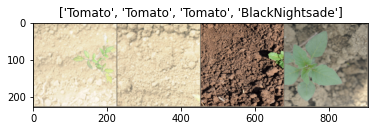

In [9]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))
print("Images' size: ", inputs.size())
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Preparing Resnet as a feature exctractor 

In [10]:
# Loading Resnet through torchvision API with pretrained weights.
conv_net = torchvision.models.resnet18(pretrained=True)
# Freeze parameters so that their gradients are not computed in backward propagation.
for param in conv_net.parameters():
    param.requires_grad = False

# Reshaping the last layers of the Network
num_ftrs = conv_net.fc.in_features
print("Num of features :", num_ftrs)

# This is a manual process, check
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html for more details.
num_classes = 4
# Adding a Fully Connected layer on top of the pretrained network
conv_net.fc = nn.Linear(num_ftrs, num_classes)

# Moving computations to GPU
conv_net = conv_net.to(device)

# Defining loss function to be used on training
criterion = nn.CrossEntropyLoss()
# Optimize only the final layers
optimizer = optim.SGD(conv_net.fc.parameters(), lr=0.001, momentum=0.9)
# Decay Lr  by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth



Num of features : 512
Adjusting learning rate of group 0 to 1.0000e-03.


### Call training

In [11]:
# This is a way to avoid errors for corrupted images
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

conv_net = train_model(conv_net, criterion, optimizer, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Adjusting learning rate of group 0 to 1.0000e-03.
train Loss: 1.1143 Acc: 0.5101
val Loss: 0.6719 Acc: 0.7900

Epoch 1/19
----------
Adjusting learning rate of group 0 to 1.0000e-03.
train Loss: 0.8790 Acc: 0.6583
val Loss: 0.8810 Acc: 0.7000

Epoch 2/19
----------
Adjusting learning rate of group 0 to 1.0000e-03.
train Loss: 0.8632 Acc: 0.6508
val Loss: 0.4868 Acc: 0.8300

Epoch 3/19
----------
Adjusting learning rate of group 0 to 1.0000e-03.
train Loss: 0.6756 Acc: 0.7563
val Loss: 0.3639 Acc: 0.8800

Epoch 4/19
----------
Adjusting learning rate of group 0 to 1.0000e-03.
train Loss: 0.6523 Acc: 0.7563
val Loss: 0.8021 Acc: 0.7400

Epoch 5/19
----------
Adjusting learning rate of group 0 to 1.0000e-03.
train Loss: 0.6058 Acc: 0.7613
val Loss: 0.3337 Acc: 0.8500

Epoch 6/19
----------
Adjusting learning rate of group 0 to 1.0000e-03.
train Loss: 0.6800 Acc: 0.7337
val Loss: 0.3249 Acc: 0.9200

Epoch 7/19
----------
Adjusting learning rate of group 0 to 1.0000e-03.
train Loss: 0.5368 

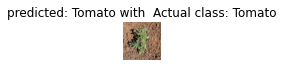

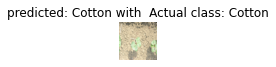

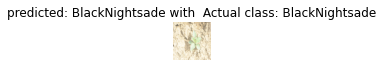

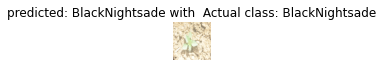

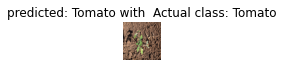

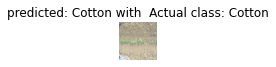

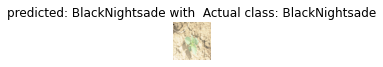

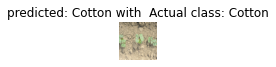

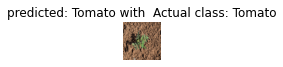

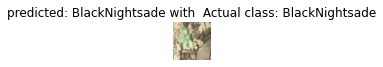

In [12]:
visualize_predictions(conv_net, 10)
plt.ioff()
plt.show()

# Exporting to ONNX format and Running the model with ONNX runtime
We are now going to use pytorch exporter to export our model in ONNX format. Then we are going to load our model on the onnx runtime and do inference on some images.

In [13]:
# Running inference with a dummy tensor to fix input sizes of the network
x = torch.randn(1, 3, 224, 224, requires_grad=True)
x = x.to(device)
torch_out = conv_net(x)

# Export the model
torch.onnx.export(
    conv_net,  # model being run
    x,  # model input (or a tuple for multiple inputs)
    "Plant_classifier.onnx",  # where to save the model (can be a file or file-like object)
    export_params=True,  # store the trained parameter weights inside the model file
    opset_version=13,
)  # the ONNX version to export the model to

In [ ]:
# load the model with the onnx API 
onnx_model = onnx.load("Plant_classifier.onnx")
onnx.checker.check_model(onnx_model)
# Print a human readable representation of the onnx graph
print(onnx.helper.printable_graph(onnx_model.graph))

In [16]:
# Pre-processing an image to feed it as input in the model.
img = Image.open(
    "/content/eden_data/val/Cotton/DSC_0653.JPG"
)  # Define an image path for inference.
resize = transforms.Resize([224, 224])
img = resize(img)
to_tensor = transforms.ToTensor()
img = to_tensor(img)
img.unsqueeze_(0)

tensor([[[[0.5255, 0.5216, 0.5216,  ..., 0.8314, 0.8275, 0.7961],
          [0.5020, 0.5216, 0.5529,  ..., 0.8353, 0.8431, 0.8392],
          [0.4980, 0.5490, 0.5922,  ..., 0.7882, 0.8157, 0.8353],
          ...,
          [0.6588, 0.6627, 0.6471,  ..., 0.7529, 0.7490, 0.7961],
          [0.6745, 0.6784, 0.6627,  ..., 0.7843, 0.7843, 0.8196],
          [0.6784, 0.6824, 0.6745,  ..., 0.7961, 0.7882, 0.8118]],

         [[0.4824, 0.4902, 0.4902,  ..., 0.7765, 0.7686, 0.7412],
          [0.4706, 0.4902, 0.5137,  ..., 0.7804, 0.7882, 0.7765],
          [0.4706, 0.5098, 0.5569,  ..., 0.7373, 0.7569, 0.7686],
          ...,
          [0.6235, 0.6275, 0.6157,  ..., 0.7098, 0.6980, 0.7333],
          [0.6314, 0.6314, 0.6235,  ..., 0.7333, 0.7255, 0.7569],
          [0.6353, 0.6314, 0.6275,  ..., 0.7451, 0.7373, 0.7569]],

         [[0.4157, 0.4275, 0.4196,  ..., 0.6824, 0.6745, 0.6549],
          [0.3922, 0.4078, 0.4275,  ..., 0.6824, 0.6941, 0.6863],
          [0.3804, 0.4196, 0.4627,  ..., 0

In [17]:
# Executing inference on the model
sess = onnxruntime.InferenceSession("Plant_classifier.onnx")


def to_numpy(tensor):
    return (
        tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()
    )


# compute ONNX Runtime output prediction
sess_inputs = {sess.get_inputs()[0].name: to_numpy(img)}
sess_outs = sess.run(None, sess_inputs)


final_pred = np.argmax(np.array(sess_outs))
print(class_names)
print(sess_outs, "\n")
print("Model's prediction : {}".format(class_names[final_pred]))

['BlackNightsade', 'Cotton', 'Tomato', 'Velvet leaf']
[array([[ 2.3863206 ,  2.4930649 , -3.1341443 , -0.07389929]],
      dtype=float32)] 

Model's prediction : Cotton


## Possible Extensions
1. Use a different pre-trained network (for instance, InceptionNet).
2. Try a different training approach where pre-trained weights are not loaded.
3. Deploy the ONNX model somewhere else eg. cloud, edge device.
3. Try different epochs and batch sizes.
4. Try different augmentation techniques.

## Bibliography

Too, E.C., Yujian, L., Njuki, S., & Ying-chun, L. (2019). A comparative study of fine-tuning deep learning models for plant disease identification. Comput. Electron. Agric., 161, 272-279.

Suh, H.K., IJsselmuiden, J., Hofstee, J.W., van Henten, E.J., (2018). Transfer learning for the classification of sugar beet and volunteer potato under field conditions. Biosystems Engineering; 174:50–65.

Espejo-Garcia, B., Mylonas, N., Athanasakos, L., & Fountas, S., (2020). Improving
Weeds Identification with a Repository of Agricultural Pre-trained Deep Neural
Networks. Computers and Electronics in Agriculture; 175 (August).

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html

https://cloudblogs.microsoft.com/opensource/2019/05/22/onnx-runtime-machine-learning-inferencing-0-4-release/

https://github.com/onnx/onnx

https://www.oreilly.com/library/view/programming-pytorch-for/9781492045342/ch04.html